# Ejercicio 1 Clustering

Primero cargamos todas las librerías a utilizar.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
%matplotlib inline

Cargamos en la variable data los datos provistos por el INDEC. Previamente ya eliminamosd todas las columnas irrelevantes y nos quedamos con las relevantes, desde BIAF01 hasta NIVEL_ACTIVIDAD_FISICA.

In [2]:
data = pd.read_csv('indec_actividad_fisica.csv', delimiter=',')

Eliminamos filas con respuestas Ns/Nc. Son menos del 10% del total, con lo cual no se pierde mucha informacion.
De todos modos seria adecuado corroborar que no haya correlacion entre aquellos que respondieron Ns/Nc y algun otro feature. Por simplicidad, asumiremos que podemos descartarlos sin mayores inconvenientes.

In [3]:
data = data[data['BIAF02'] != 9999]
data = data[data['BIAF04'] != 9999]
data = data[data['BIAF06'] != 9999]
data = data[data['BIAF07'] != 9999]

Ahora bien, las encuestas entre aquellos que realizan al menos algo de actividad física, y aquellos que no realizan nada, son muy distintas. Los que no realizan actividad física no fueron consultados sobre las preguntas BIAF08, BIAF10_01, BIAF10_02, BIAF10_03 y BIAF10_04, que sí fueron preguntadas a los que realizan actividad. Además, trivialmente recibieron calificación 3 en NIVEL_ACTIVIDAD_FISICA. Por este motivo decidimos analizar separadamente estos dos grupos de personas.
Trabajaremos con aquellos que sí realizan algo de actividad, que tienen más features. Llamamos "act" al DF que almacena dichas personas. Para ello, tiramos las filas sin respuesta a la pregunta BIAF09 (ya que, si realiza actividad, debe haberla respondido), y eliminamos la columna BIAF08, porque en este caso ninguno tendrá respuesta a esa pregunta. Además, en los casos donde no realiza un tipo de actividad (fuerte, moderada o ccaminata) no hay respuesta a la pregunta sobre el tiempo dedicado a dicha actividad, con lo cual en la tabla aparecerá NaN. Pero esto es equivalente a responder que el tiempo dedicado es 0 minutos, con lo cual llenamos esos casillleros con ceros.

In [4]:
act = data.dropna(subset=['BIAF09']).drop(columns = ['BIAF08']).fillna(0)

Ahora bien, algunos features son ccategóricos (cantidad posible de respuestas finita), mientras que otros son continuos. Para los categóricos, utilizamos dummy variables (o one-hot encoding) para hacer clustering.

In [5]:
categorical_features = ['BIAF01','BIAF03','BIAF05','BIAF09','BIAF10_01','BIAF10_02','BIAF10_03','BIAF10_04','NIVEL_ACTIVIDAD_FISICA']
for col in categorical_features:
    dummies = pd.get_dummies(act[col], prefix=col)
    act = pd.concat([act, dummies], axis=1)
    act.drop(col, axis=1, inplace=True)

Antes de proceder a hacer clustering, normalizamos los datos.

In [6]:
mms = MinMaxScaler()
mms.fit(act)
act_norm = mms.transform(act)

Vamos a usar k-Means como algoritmo de clustering. Como no sé la cantidad de clusters, lo corro para varios valores de k, y utilizo el elbow-method para hallar un k adecuado. En cada caso guardo la "inercia", es decir, la suma del cuadrado de las distancias de las muestras a su respectivo cluster.

In [7]:
sum_dist_sq = []
K = (1,2,3,4,6,8,10,15,20,25,30,40,50,70,100,150,200,250)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(act_norm)
    sum_dist_sq.append(km.inertia_)

Grafico inercias vs. k, y elijo el k del "codo" del grafico

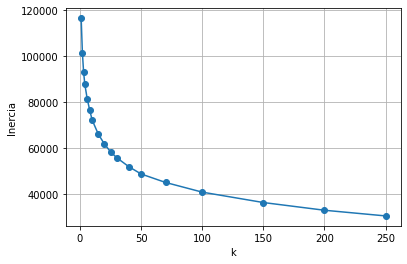

In [8]:
plt.plot(K, sum_dist_sq, 'o-')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.grid(True)
plt.show()

Vemos que alrededor de k=30 se encuentra el codo del gráfico, con lo cual elegimos dicho valor. Hacemos entonces k-Means con este k y guardamos los resultados de los centroides y los labels.

In [9]:
k = 30
km = KMeans(n_clusters=k)
km = km.fit(act_norm)
labels = km.predict(act_norm)
centroids_norm = km.cluster_centers_

Desnormalizo las coordenadas de los clusters.

In [10]:
centroids = mms.inverse_transform(centroids_norm)

Finalmente con estos datos puedo obtener información sobre las características promedio de los integrantes de cada uno, así como también usar los labels para hallar, por ejemplo, cuán homogéneamente están distribuidos los encuestados. Por ejemplo, comparemos el cluster más chico con el más grande. Para ello, hallemos la cantidad de personas en cada cluster.

In [11]:
clusters_size = []
for i in range(k):
    clusters_size.append(np.count_nonzero(labels==i))

print('Mín cluster: ', min(clusters_size))
print('Máx cluster: ', max(clusters_size))

Mín cluster:  254
Máx cluster:  1300


Observamos que la diferencia no es excesiva (no llega a ser un orden de magnitud), cada cluster abarca una relativamente gran porción de los encuestados.
Podemos ahora preguntarnos cosas sobre los centroides. A modo de ejemplo, elegimos uno de ellos aleatoriamente (el primero) y vemos el tiempo de cada tipo de actividad de sus encuestados. Esto se corresponde con las preguntas BIAF02, BIAF04, y BIAF06, que son las columnas 0, 1 y 2 de la tabla luego de hacer dummy variables.

In [12]:
centroids = np.round(centroids,2)
print('Intenso: ', centroids[0,0])
print('Moderado: ', centroids[0,1])
print('Caminata: ', centroids[0,2])

Intenso:  27.63
Moderado:  516.51
Caminata:  247.1


Para intentar visualizar algunos clusters podemos aplicar reducción dimensional. Sin embargo, pasar de las 50 features obtenidas luego de hacer dummy variables a sólo 2 termina eliminando la mayor parte de la información.

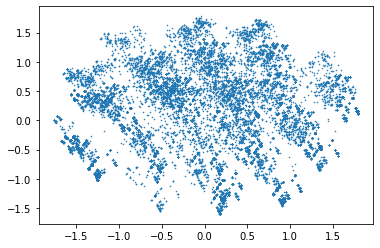

In [13]:
pca = PCA(n_components=2)
pc = pca.fit_transform(act_norm)

plt.scatter(pc[:,0], pc[:,1], s=0.3)
plt.show()

Vemos que no hay un claro agrupamiento de las muestras. Si calulamos la varianza retenida por llas dos componentes principales, obtenemos

In [14]:
print(pca.explained_variance_ratio_)

[0.17282104 0.11139558]


Vemos que su suma no llega a ser el 30% del total, con lo cual se está perdiendo más del 70% de la información.